In [1]:
import tensorflow as tf
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

plt.style.use('ggplot')
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 
  
# metadata 
print(breast_cancer_wisconsin_diagnostic.metadata) 
  
# variable information 
print(breast_cancer_wisconsin_diagnostic.variables) 


{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'published_in': 'Electronic imaging', 'year': 1993, 'url': 'https://www.semanticscholar.org/paper/53

In [2]:
import pandas as pd
print(y)
print(X)
# Data preprocessing
data=pd.concat([X,y],axis=1)
print(data)
# if Malignant(M):1, if benign(B):0
data['Diagnosis']=data['Diagnosis'].apply(lambda val: 1 if val == 'M' else 0)
#describe the data
data.describe()
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

    Diagnosis
0           M
1           M
2           M
3           M
4           M
..        ...
564         M
565         M
566         M
567         M
568         B

[569 rows x 1 columns]
     radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0      17.99     10.38      122.80  1001.0      0.11840       0.27760   
1      20.57     17.77      132.90  1326.0      0.08474       0.07864   
2      19.69     21.25      130.00  1203.0      0.10960       0.15990   
3      11.42     20.38       77.58   386.1      0.14250       0.28390   
4      20.29     14.34      135.10  1297.0      0.10030       0.13280   
..       ...       ...         ...     ...          ...           ...   
564    21.56     22.39      142.00  1479.0      0.11100       0.11590   
565    20.13     28.25      131.20  1261.0      0.09780       0.10340   
566    16.60     28.08      108.30   858.1      0.08455       0.10230   
567    20.60     29.33      140.10  1265.0      0.11780       0.27700   
568  

In [3]:
# check for null values  
data.isna().sum()

radius1               0
texture1              0
perimeter1            0
area1                 0
smoothness1           0
compactness1          0
concavity1            0
concave_points1       0
symmetry1             0
fractal_dimension1    0
radius2               0
texture2              0
perimeter2            0
area2                 0
smoothness2           0
compactness2          0
concavity2            0
concave_points2       0
symmetry2             0
fractal_dimension2    0
radius3               0
texture3              0
perimeter3            0
area3                 0
smoothness3           0
compactness3          0
concavity3            0
concave_points3       0
symmetry3             0
fractal_dimension3    0
Diagnosis             0
dtype: int64

In [4]:
#EDA
# Plotting the features and values
plt.figure(figsize=(80, 80))

for plotnumber, column in enumerate(data.columns, start=1):
    if plotnumber <= 30:
        ax = plt.subplot(5, 6, plotnumber)
        sns.histplot(data[column], kde=True, color='skyblue', bins=30)
        
        ax.set_ylabel('Measure', fontsize=50)  # Set y-axis label
        ax.set_xlabel(column, fontsize=50)     # Set x-axis label
        ax.tick_params(labelsize=40)  # Increase tick label font size

plt.tight_layout()
plt.show()

In [5]:
# checking for outliers using boxplots and calculating the data skewedness

plt.figure(figsize=(80, 80))
plotnumber = 1

for plotnumber, column in enumerate(data.columns, start=1):
    if plotnumber <= 30:
        
        ax = plt.subplot(5, 6, plotnumber)
        sns.histplot(data[column], kde=True, color='skyblue', bins=30)
        
        ax.set_ylabel('Measure', fontsize=50)  # Set y-axis label
        ax.set_xlabel(column, fontsize=50)     # Set x-axis label
        ax.tick_params(labelsize=40)  # Increase tick label font size
        
        # box plot for detecting outliers
        plt.twinx()
        sns.boxplot(x=data[column], color='orange', linewidth=1)
        plt.ylabel('')
        
        # skewness
        skewness = data[column].skew()
        plt.title(f'Skewness: {skewness:.2f}', fontsize=40)  # Increase title font size

plt.tight_layout()
plt.show()

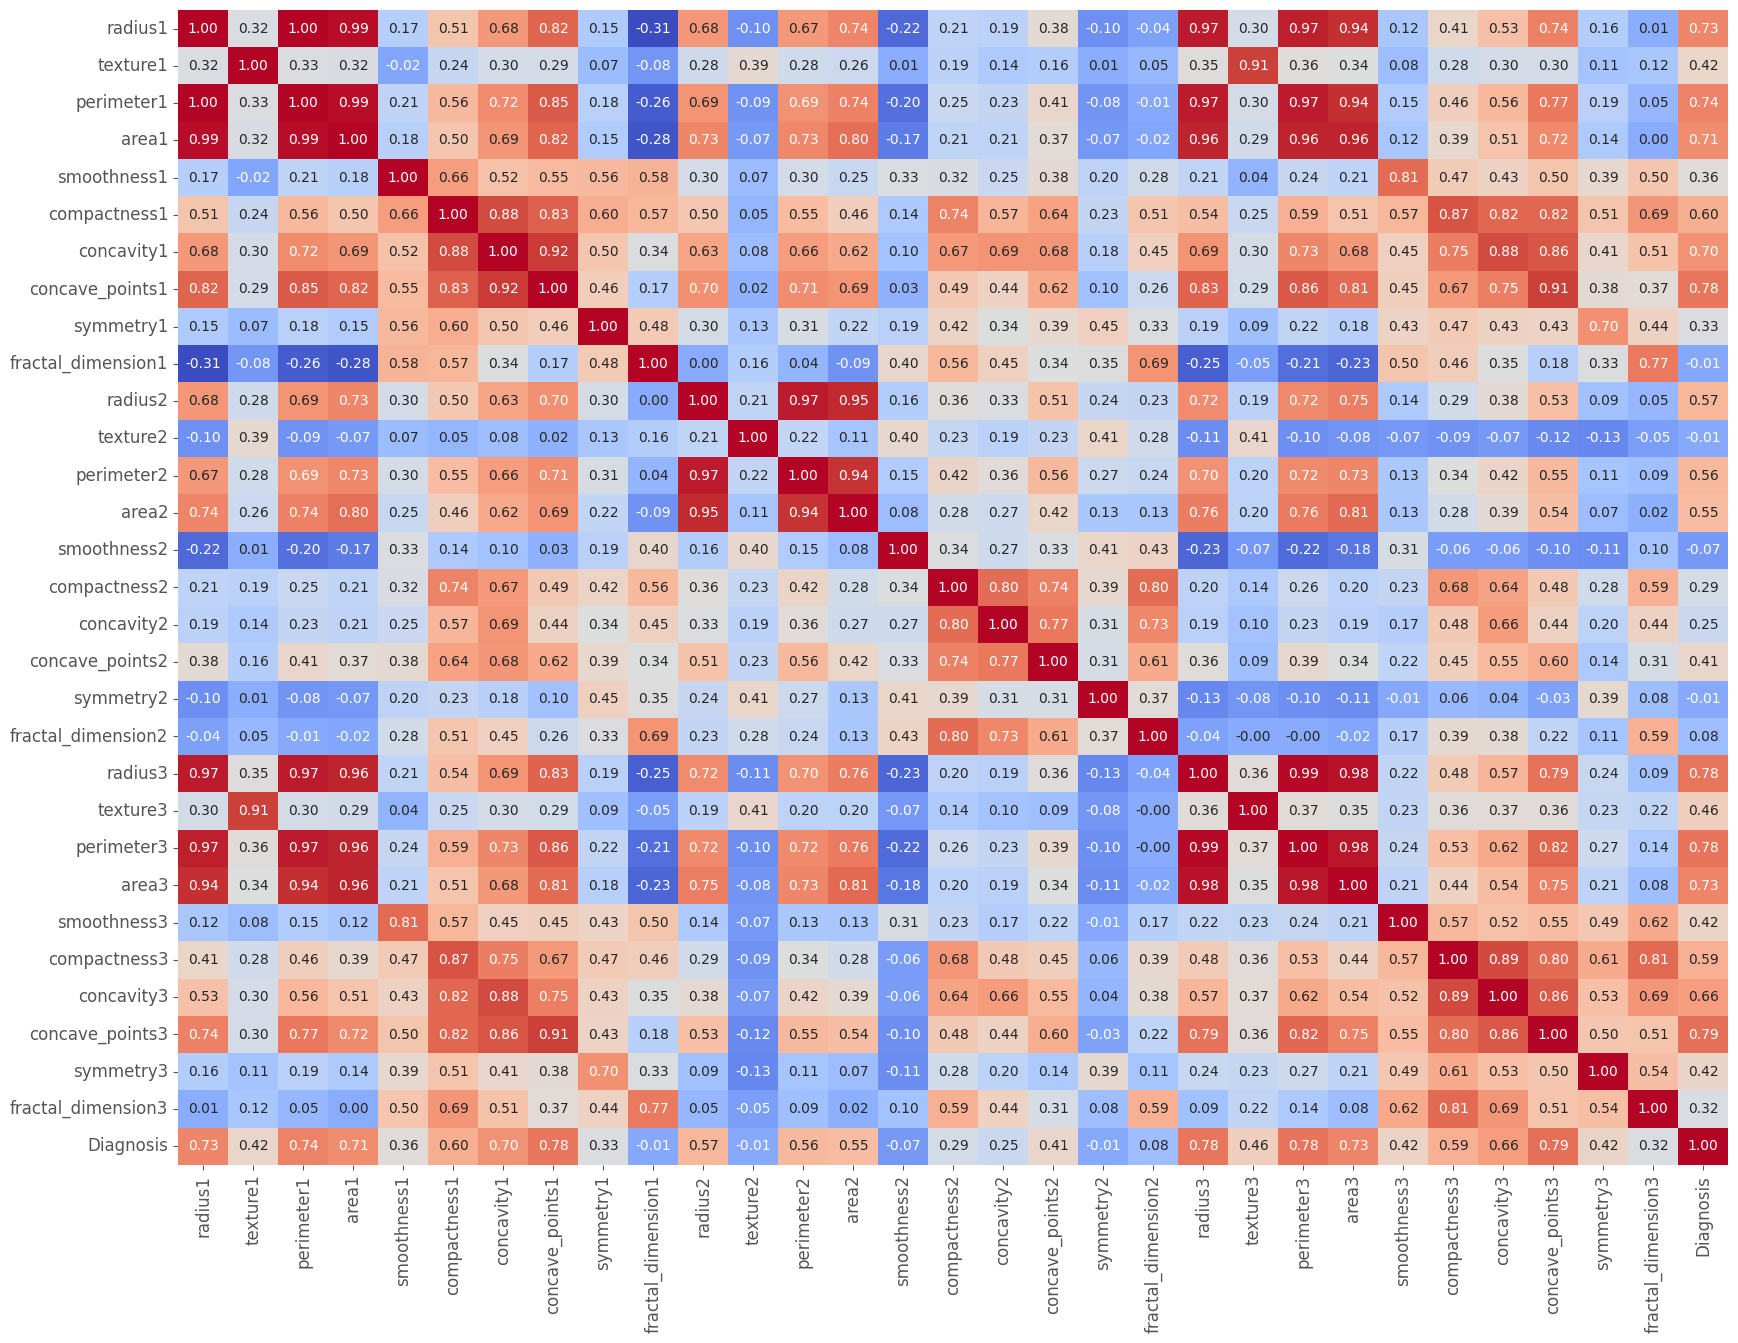

In [6]:
# Check if features are uncorrelated:
plt.figure(figsize=(20, 15))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [7]:
# Remove highly correlated features
correlation_mat = data.corr()
#correlation threshold
threshold = 0.95 #setting to 0.95

highly_correlated = correlation_mat[abs(correlation_mat) > threshold]
highly_correlated = highly_correlated[highly_correlated != 1].stack().index.tolist()

# which ones to remove
remove = set()
for (feature1, feature2) in highly_correlated:
    remove.add(feature1 if correlation_mat.loc[feature1, feature2] > 0 else feature2)

# drop highly correlated features from the dataframe
data = data.drop(remove, axis=1)

print(data)
print(f"The new dataframe has {data.shape[1]} columns")

     texture1  smoothness1  compactness1  concavity1  concave_points1  \
0       10.38      0.11840       0.27760     0.30010          0.14710   
1       17.77      0.08474       0.07864     0.08690          0.07017   
2       21.25      0.10960       0.15990     0.19740          0.12790   
3       20.38      0.14250       0.28390     0.24140          0.10520   
4       14.34      0.10030       0.13280     0.19800          0.10430   
..        ...          ...           ...         ...              ...   
564     22.39      0.11100       0.11590     0.24390          0.13890   
565     28.25      0.09780       0.10340     0.14400          0.09791   
566     28.08      0.08455       0.10230     0.09251          0.05302   
567     29.33      0.11780       0.27700     0.35140          0.15200   
568     24.54      0.05263       0.04362     0.00000          0.00000   

     symmetry1  fractal_dimension1  texture2  smoothness2  compactness2  ...  \
0       0.2419             0.07871    0.905

In [153]:
import ydf
from sklearn.model_selection import KFold
import numpy as np
def opt (b):
    mod=[]
    eval=[]
    kf=KFold(n_splits=b,shuffle=True, random_state=50)
    for traI, testI in kf.split(data):
        train=data.iloc[traI]
        test=data.iloc[testI]
        model = ydf.RandomForestLearner(label='Diagnosis', num_trees=10,max_depth=5).train(train)
        evaluation=model.evaluate(test)
        mod.append(model)
        eval.append(evaluation.accuracy)
        print(evaluation.accuracy)
    index=np.argmax(eval)
    mo=mod[index]
    return mo,eval[index]

In [159]:
m,acc=opt(30)
print(acc)
fold=[]
models=[]
accs=[]
batch=[]
for b in range(2,10,1):
    m,acc=opt(b)
    fold.append(b)
    print("acc",acc)
    models.append(m)
    accs.append(acc)
    batch.append(b)
print(acc.size)


Train model on 550 examples
Model trained in 0:00:00.019477
1.0
Train model on 550 examples
Model trained in 0:00:00.025693
0.9473684210526315
Train model on 550 examples
Model trained in 0:00:00.030198
0.8947368421052632
Train model on 550 examples
Model trained in 0:00:00.034753
0.8947368421052632
Train model on 550 examples
Model trained in 0:00:00.025309
0.9473684210526315
Train model on 550 examples
Model trained in 0:00:00.016358
0.9473684210526315
Train model on 550 examples
Model trained in 0:00:00.016424
0.9473684210526315
Train model on 550 examples
Model trained in 0:00:00.017585
0.8421052631578947
Train model on 550 examples
Model trained in 0:00:00.024421
0.9473684210526315
Train model on 550 examples
Model trained in 0:00:00.016689
0.8947368421052632
Train model on 550 examples
Model trained in 0:00:00.019974
0.9473684210526315
Train model on 550 examples
Model trained in 0:00:00.015843
0.9473684210526315
Train model on 550 examples
Model trained in 0:00:00.016288
0.89473

Text(0.5, 0, 'Batch Size')

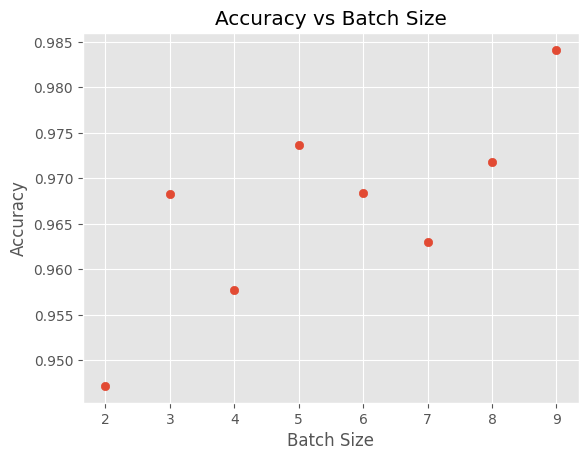

In [160]:
plt.scatter(batch,accs)
plt.title("Accuracy vs Batch Size")
plt.ylabel("Accuracy")
plt.xlabel("Batch Size")

In [167]:
bestINdex=np.argmax(accs)
print(bestINdex)
bestModel=models[bestINdex]
print(accs)
print(data.iloc[1:2])
print(data['Diagnosis'].iloc[200:201])

7
[0.9471830985915493, 0.9682539682539683, 0.9577464788732394, 0.9736842105263158, 0.968421052631579, 0.9629629629629629, 0.971830985915493, 0.9841269841269841]
   texture1  smoothness1  compactness1  concavity1  concave_points1  \
1     17.77      0.08474       0.07864      0.0869          0.07017   

   symmetry1  fractal_dimension1  texture2  smoothness2  compactness2  ...  \
1     0.1812             0.05667    0.7339     0.005225       0.01308  ...   

   symmetry2  fractal_dimension2  texture3  smoothness3  compactness3  \
1    0.01389            0.003532     23.41       0.1238        0.1866   

   concavity3  concave_points3  symmetry3  fractal_dimension3  Diagnosis  
1      0.2416            0.186      0.275             0.08902          1  

[1 rows x 22 columns]
200    0
Name: Diagnosis, dtype: int64


In [168]:
def p(m, dat):
    pr=m.predict(dat)
    print(pr)
    if pr>0.5:
        return 1
    else:
        return 0
    
res=p(bestModel,data.iloc[200:201])
print(res)
def all(m,dat):
    pred=m.predict(dat)
    rest=[1 if pre>0.5 else 0 for pre in pred]
    return rest
result_ALL=all(bestModel,data)
result_df=pd.DataFrame(result_ALL)
#result_df["Prediction"]=result_ALL
print(result_df)
print(result_ALL)
print("\n",data['Diagnosis'])
eval=bestModel.evaluate(data)
eval

[0.]
0
     0
0    1
1    1
2    1
3    1
4    1
..  ..
564  1
565  1
566  1
567  1
568  0

[569 rows x 1 columns]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Evaluation()

In [169]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(data['Diagnosis'],result_df)
print(mse)

0.0351493848857645


[0.04745166959578207, 0.029876977152899824, 0.05799648506151142, 0.028119507908611598, 0.033391915641476276, 0.04745166959578207, 0.040421792618629174, 0.0351493848857645]
0.028119507908611598


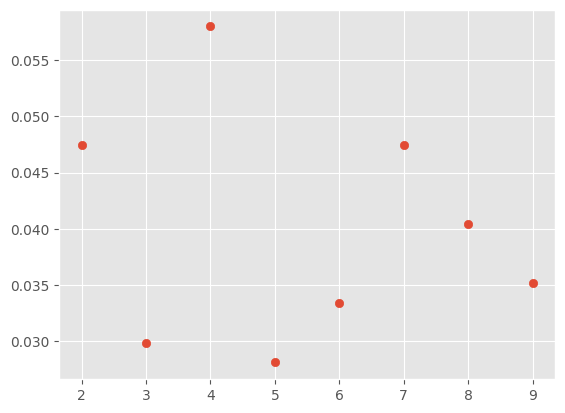

In [171]:
MSE=[]
for mo in models:
    MSE.append(mean_squared_error(data['Diagnosis'],all(mo,data)))
plt.scatter(batch, MSE)
print(MSE)
print(MSE[np.argmin(MSE)])

In [110]:
import tensorflow as tf
import matplotlib.pyplot as plt
def load_image(path):
    image=tf.io.read_file(path)
    image=tf.image.decode_image(image)
    image=tf.image.resize(image,[200,200])
    image=image/255.0
    return image
imageT = load_image("C:/Users/amend/Desktop/Bcc/INbreast+MIAS+DDSM Dataset/Malignant Masses/13269.png")
imq3n=load_image("C:/Users/amend/Desktop/Bcc/INbreast+MIAS+DDSM Dataset/Benign Masses/10861.png")



(200, 200, 1)
(200, 200)


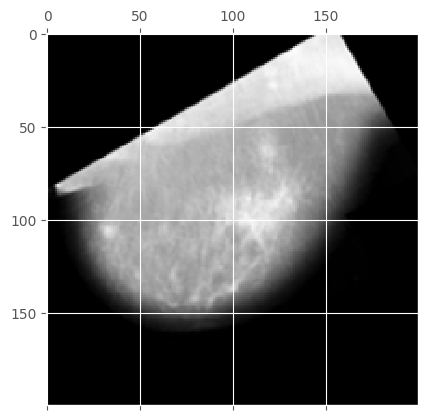

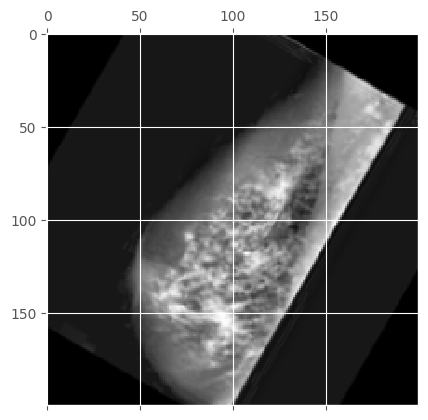

In [111]:
import numpy as np
imag=np.squeeze(imageT)
plt.matshow(imag)
plt.gray()
plt.matshow(imq3n)
plt.gray()
print(imageT.shape)
print(imag.shape)


In [96]:
import numpy as np
def extract_patches(images, patch_size=15):
    num_images, height, width = images.shape
    num_patches_x = width - patch_size + 1
    num_patches_y = height - patch_size + 1
    patches = []

    for image in images:
        for i in range(num_patches_y):
            for j in range(num_patches_x):
                patch = image[i:i+patch_size, j:j+patch_size]
                patches.append(patch)

    return np.array(patches)


In [29]:
import pathlib

In [30]:
archive=tf.keras.preprocessing.image_dataset_from_directory("C:/Users/amend/Desktop/Bcc/INbreast+MIAS+DDSM Dataset",color_mode='grayscale',image_size=(32, 32))

Found 24576 files belonging to 2 classes.


In [31]:
archive
print(archive.class_names)

['Benign Masses', 'Malignant Masses']


In [92]:
listM=[]
listL=[]
for images, labels in archive:

    for i,image in enumerate(images):
        first_image = images[0].numpy().astype('uint8')
        if labels[i]== 1:

            listM.append(first_image)
        else:
            listL.append(first_image)
        first_label = labels[0].numpy()
im=np.array(listM)
il=np.array(listL)
x=np.concatenate([im,il],axis=0)
y=np.concatenate([np.ones(len(im)),np.zeros(len(il))],axis=0)


In [113]:
from sklearn.model_selection import train_test_split
print(im.shape)
trainx,testx,trainy,testy=train_test_split(x,y,test_size=0.25,random_state=42)
trainx=np.squeeze(trainx)
testx=np.squeeze(testx)
#trainx=trainx[:1000]
#X=extract_patches(trainx)
X=trainx
print(trainx[1].shape)

print("X:",X.shape)
print(trainx.shape)
print(testx.shape)

(13710, 32, 32, 1)
(32, 32)
X: (18432, 32, 32)
(18432, 32, 32)
(6144, 32, 32)


(2, 32, 32)


TypeError: Invalid shape (1024,) for image data

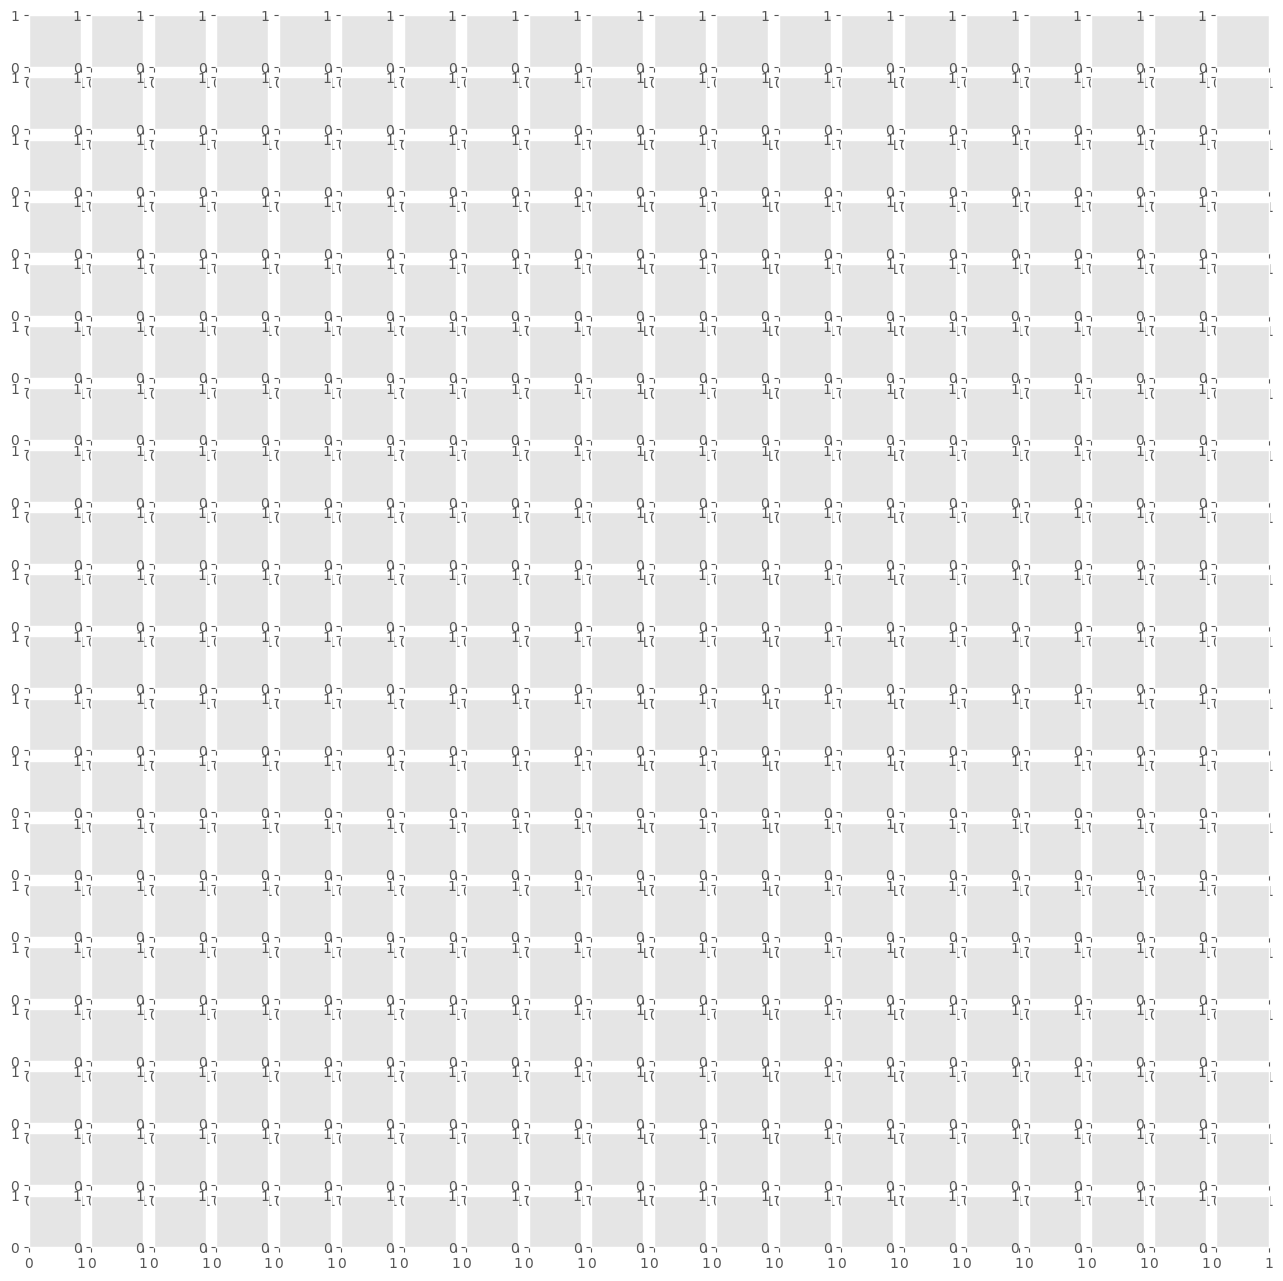

In [117]:
print(testx[1:3].shape)
fig,axis=plt.subplots(20,20,figsize=(16,16))
for i,ax in enumerate(axis.flat):
    ax.imshow(X[i])
    ax.axis=('off')
plt.show()
X=X.reshape(len(X),-1)
Y=trainy
X=X.astype(float)/255.0
print(X.shape)

# of clusters: 1  |  inertia: 683482.6072044927


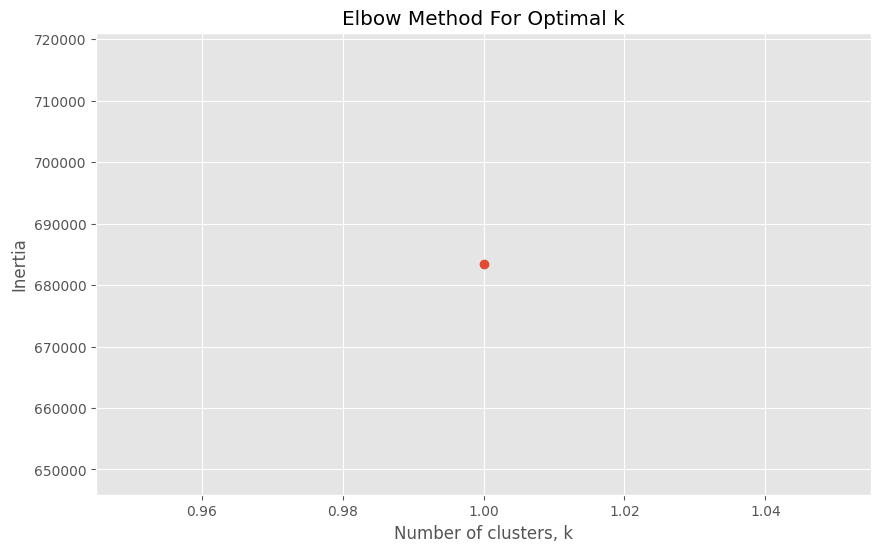

In [115]:
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
inertiass=[]
#ks = range(8000, 50001, 1000)
ks = range(1, 2)


kmeans1 = MiniBatchKMeans(n_clusters=2, n_init='auto')
kmeans1.fit(X)
print(f"# of clusters: {k}  |  inertia: {kmeans1.inertia_}")
inertiass.append(kmeans1.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(ks, inertiass, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


# of clusters: 1  |  inertia: 0.06908888715427988


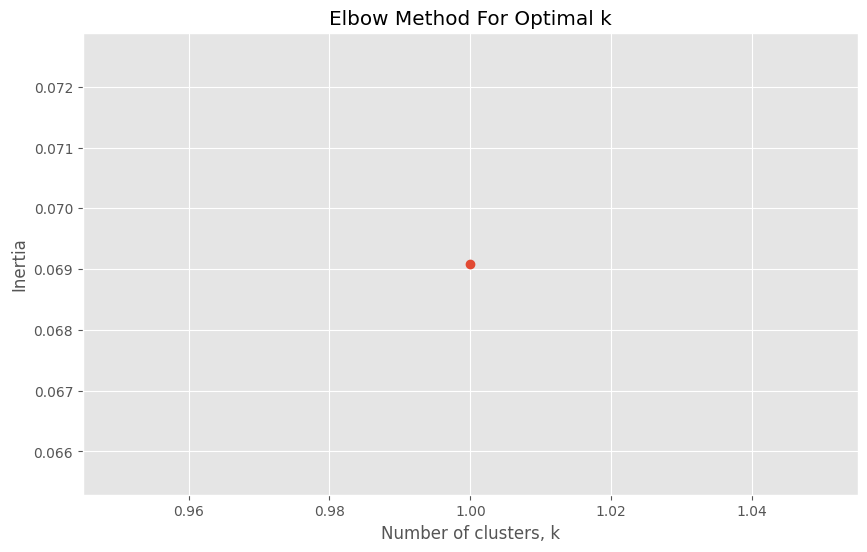

In [44]:
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
inertias=[]
#ks = range(8000, 50001, 1000)
ks = range(1, 2)


for k in ks:
    kmeans = MiniBatchKMeans(n_clusters=800000, n_init='auto')
    kmeans.fit(X)
    print(f"# of clusters: {k}  |  inertia: {kmeans.inertia_}")
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


In [80]:
# ine=np.argmin(inertias)
# clust=(8000+1000*ine)
# finalk=MiniBatchKMeans(n_clusters=clust, n_init='auto')
# finalk(X)
xx=X=X.reshape(len(X),-1)
Y=trainy
X=X.astype(float)/255.0
kmeans.predict(extract_patches(trainx))

ValueError: Found array with dim 3. MiniBatchKMeans expected <= 2.